In [2]:
import simulation
import numpy as np
from scipy.stats import rayleigh

L = 50.0
M = 4

r_values = np.arange(0, 5.01, 0.01)

# 2D standard normal distribution radial density
# The radial distribution for a 2D normal is proportional to Rayleigh distribution with scale 1 (standard normal case)
def density(r):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * r**2)

radial_density_values = density(r_values)
q_values = np.arange(0, 1.0, 0.001)
inverse_radial_values = rayleigh.ppf(q_values, scale=1.0)
g2 = simulation.PyGrid2(
    M=M,
    areaLen=[L, L],
    cellCount=[L, L],
    isPeriodic=True,
    birthRates=[1]*M,
    deathRates=[0]*M,
    ddMatrix=[0.1, 0.3, 0.3, 0.3,
              0.3, 0.1, 0.3, 0.3,
              0.3, 0.3, 0.1, 0.3,
              0.3, 0.3, 0.3, 0.1,],         # 1x1 for single species
    birthX=[q_values.tolist()]*M,     # example
    birthY=[inverse_radial_values.tolist()]*M,
    deathX_=[ [ r_values.tolist()]*M]*M,
    deathY_=[ [ radial_density_values.tolist() ]*M ]*M,
    cutoffs=[5.0]*M*M,
    seed=42,
    rtimeLimit=7200.0
)


# Parameters
N = 1000  # Number of [x, y] pairs per group

# Generate the list
coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(N)]
    coordinates.append(group)

g2.placePopulation(coordinates)

print("Birth rate:", g2.total_birth_rate)
print("Death rate:", g2.total_death_rate)

Birth rate: 4000.0
Death rate: 1607.2306316657432


In [3]:
import pandas as pd

data = list()

for t in range(300):
    for c in range(g2.get_num_cells()):
        for n in range(M):
            coords = g2.get_cell_coords(c,n)
            for i in range(len(coords)):
                x,y = coords[i]
                data.append([t,x,y,n])
    g2.run_for(1)
    print(t, g2.total_population)

0 6397
1 8604
2 9702
3 10396
4 10844
5 11217
6 11540
7 12092
8 12759
9 13455
10 14352
11 15351
12 16586
13 17338
14 18197
15 18705
16 19168
17 19461
18 19853
19 20175
20 20362
21 20668
22 20520
23 20891
24 21045
25 21054
26 21050
27 20906
28 21254
29 21426
30 21656
31 21624
32 21443
33 21451
34 21594
35 21510
36 21776
37 21699
38 21368
39 21573
40 21752
41 21530
42 21848
43 21850
44 21872
45 21836
46 22112
47 21835
48 22119
49 22125
50 22187
51 22217
52 22466
53 22267
54 21978
55 22176
56 22355
57 22543
58 22483
59 22463
60 22396
61 22278
62 22315
63 22082
64 22149
65 22486
66 22569
67 22346
68 22676
69 22545
70 22547
71 22713
72 22525
73 22798
74 22641
75 22605
76 22381
77 22249
78 22470
79 22708
80 22694
81 22794
82 22763
83 22884
84 22593
85 22559
86 22650
87 22681
88 22741
89 22592
90 22667
91 22573
92 22884
93 22571
94 22653
95 23064
96 22782
97 22686
98 22815
99 22770
100 22864
101 22800
102 23012
103 23124
104 22832
105 22792
106 22955
107 23150
108 23389
109 23211
110 22959
111

In [4]:
df = pd.DataFrame(columns=['time','x','y','s'],data=data)
df

,time,x,y,s
0,0,1.597115,0.267862,1
1,0,2.649172,0.957643,1
2,0,2.163110,0.971354,1
3,0,2.713497,0.443013,2
4,0,2.288377,0.971794,3
...,...,...,...,...
6820182,299,49.829177,49.771637,3
6820183,299,49.262187,49.149780,3
6820184,299,49.262597,49.922025,3
6820185,299,49.768847,49.529497,3


In [5]:
from matplotlib import animation
movie_writer = animation.FFMpegWriter(fps=2, codec='h264', extra_args=['-vcodec', 'libx264'])

Animation saved as points_animation.mp4


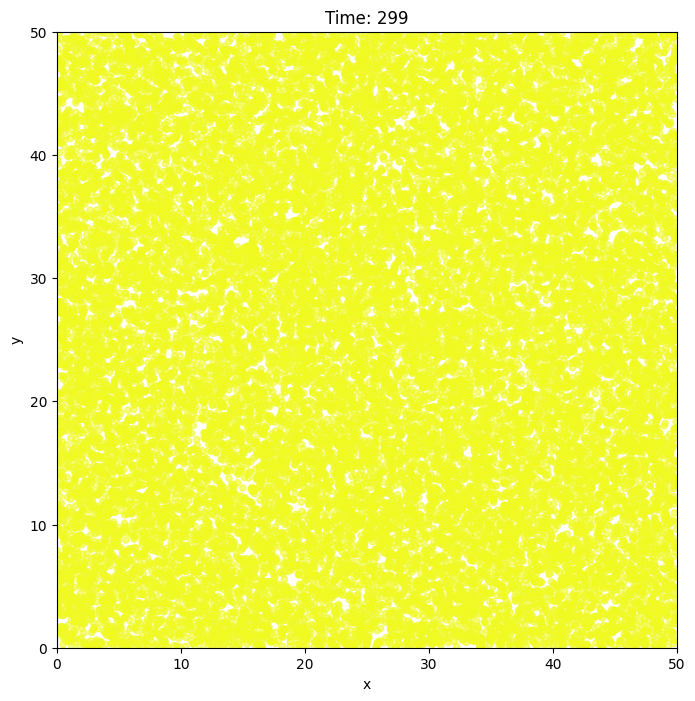

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.rcParams['animation.ffmpeg_path'] = 'C:/Users/radia/ffmpeg/bin/ffmpeg'

df = df.sort_values('time')

# Parameters
output_file = "points_animation.mp4"

# MP4 Video Generation
fig, ax = plt.subplots(figsize=(8, 8))

# Set axis limits
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
sc = ax.scatter([], [], c=[], cmap='plasma', s=20, alpha=0.6)

# Animation function
def update(frame):
    current_df = df[df['time'] == frame]
    sc.set_offsets(current_df[['x', 'y']].values)
    sc.set_array(current_df['s'].values)
    ax.set_title(f"Time: {frame}")
    return sc,

ani = FuncAnimation(fig, update, frames=df['time'].nunique(), blit=True)

# Save as MP4
ani.save(output_file, writer=movie_writer)
print(f"Animation saved as {output_file}")